### Masked dataset

In [2]:
import tensorflow as tf 
import numpy as np
import pandas as pd

seed = 13
batch_size = 16 
img_height = 224 
img_width = 224 
img_size = (img_height, img_width)
size = (img_height, img_width)
data_dir = 'D:\Downloads\masked_images'
weight_path = 'D:\Downloads\\brucechou1983_CheXNet_Keras_0.3.0_weights.h5'
best_model_path = 'D:\Documentos\projeto convs\models\masked'


## Split do dataset.

full_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.14,
    subset="training",
    seed= seed,
    image_size= img_size,
    batch_size = batch_size
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.14, #98 imagens pra teste
    subset="validation",
    seed= seed,
    image_size= img_size,
    batch_size = batch_size
)

full_train_ds.shuffle(1000, reshuffle_each_iteration = False, seed = seed) #embaralha e desativa shuffle pois usar o map que virá depois itera o dataset, o reshuffle pode causar vazamento de dados

def recover(x, y):
    return y

def is_val(x, y):
    return x%6 == 0 # 1/6 do dataset ~ 100 imagens pra validação

def is_train(x,y):
    return not is_val(x,y)

val_ds = full_train_ds.enumerate().filter(is_val).map(recover)
train_ds = full_train_ds.enumerate().filter(is_train).map(recover)

full_train_ds.shuffle(1000, reshuffle_each_iteration = True, seed = seed) #reseta o shuffle para acontecer o shuffle entre épocas do treino


import keras
from keras import layers
import keras_tuner as kt

channels = tuple([3])
shape = size + channels

def get_model(hp):
    inputs = keras.Input(shape = shape)
    x = layers.RandomRotation(0.05)(inputs) #tentar rotacionar menos
    x = layers.Rescaling(scale=1./127.5, offset=-1)(x) #normalização "manual"

    chexnet = tf.keras.applications.DenseNet121(weights= None,
                                                include_top = False, 
                                                input_tensor = x,
                                                input_shape = shape
                                               )

    out = tf.keras.layers.Dense(14, activation='sigmoid')(chexnet.output)
    model = tf.keras.Model(inputs, out)
    
    for layer in chexnet.layers:
        layer.trainable = False
    model.load_weights(weight_path)
    
    x =  layers.GlobalAveragePooling2D()(chexnet.output)
    preds = layers.Dense(units = 1, activation = 'sigmoid', name='prediction')(x)
    model = tf.keras.Model(model.input, preds)
    #Tune LR
    hp_lr = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
    opt = tf.keras.optimizers.SGD(learning_rate = hp_lr)
    model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])        
    return model

tuner = kt.RandomSearch(get_model, objective = kt.Objective('val_accuracy', direction = 'max'), max_trials = 3  , seed = 1337, overwrite = True)

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#Callbacks
checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', verbose=1, 
                                save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                patience=3, 
                                verbose=1, mode='min', min_delta=0.0001, cooldown=2, min_lr=1e-6)

early = EarlyStopping(monitor="val_loss", 
                    mode="min", 
                    patience=15) 

callbacks = [checkpoint, early, reduceLROnPlat]

Found 704 files belonging to 2 classes.
Using 606 files for training.
Found 704 files belonging to 2 classes.
Using 98 files for validation.


Hyperparameter Search

In [2]:
tuner.search(train_ds, batch_size = batch_size, epochs = 100, validation_data = val_ds, callbacks = callbacks)
best_hps = tuner.get_best_hyperparameters(5)
print(f"Best learning rate was {best_hps[1].get('learning_rate')}.")
model = get_model(best_hps[0])

Trial 3 Complete [00h 14m 46s]
val_accuracy: 0.7946428656578064

Best val_accuracy So Far: 0.7946428656578064
Total elapsed time: 00h 28m 50s
INFO:tensorflow:Oracle triggered exit
Best learning rate was 0.001.


### Full Training

In [3]:
lr = kt.HyperParameters()
lr.Fixed(name = 'learning rate', value = 1e-3)
model = get_model(lr)
history = model.fit(full_train_ds, batch_size = batch_size, epochs = 100, verbose = 2, validation_data = test_ds, callbacks = callbacks)

Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.69363, saving model to D:\Documentos\projeto convs\models\masked
38/38 - 52s - loss: 0.7006 - accuracy: 0.5182 - val_loss: 0.6936 - val_accuracy: 0.5408 - lr: 0.0100 - 52s/epoch - 1s/step
Epoch 2/100

Epoch 00002: val_loss improved from 0.69363 to 0.69354, saving model to D:\Documentos\projeto convs\models\masked
38/38 - 39s - loss: 0.6995 - accuracy: 0.4884 - val_loss: 0.6935 - val_accuracy: 0.4694 - lr: 0.0100 - 39s/epoch - 1s/step
Epoch 3/100

Epoch 00003: val_loss improved from 0.69354 to 0.68213, saving model to D:\Documentos\projeto convs\models\masked
38/38 - 39s - loss: 0.6908 - accuracy: 0.5281 - val_loss: 0.6821 - val_accuracy: 0.5408 - lr: 0.0100 - 39s/epoch - 1s/step
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.68213
38/38 - 13s - loss: 0.6923 - accuracy: 0.5132 - val_loss: 0.6830 - val_accuracy: 0.6327 - lr: 0.0100 - 13s/epoch - 341ms/step
Epoch 5/100

Epoch 00005: val_loss improved from 0.68213 to 0.67

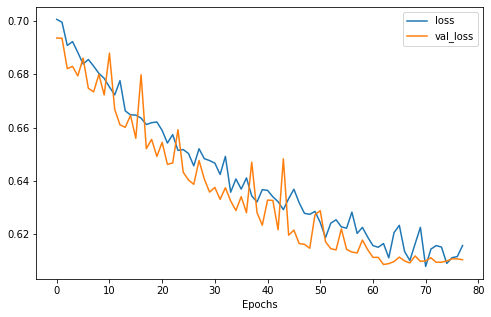

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

model.load_weights(best_model_path)
df = pd.DataFrame(history.history)[['loss', 'val_loss']]
pd.DataFrame(df).plot(figsize=(8,5))
plt.xlabel('Epochs')
plt.savefig('fullmaskedloss.png')
plt.show()

#adicionar matriz de confusão


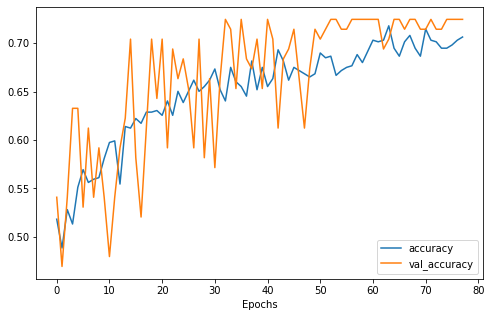

In [5]:
df = pd.DataFrame(history.history)[['accuracy', 'val_accuracy']]
pd.DataFrame(df).plot(figsize=(8,5))
plt.xlabel('Epochs')
plt.savefig('fullmaskedacc.png')
plt.show()

In [6]:
def get_binary_labels(ds, model):
    ''' TF.dataset --> numpy.array
    takes tensorflow dataset for data with binary classification and returns array
    with an int representing the class for each element'''
    labels = np.array([])
    preds = np.array([])
    for x, y in ds.as_numpy_iterator():
        preds = np.append(preds, model.predict(x))
        labels = np.append(labels, y)
    labels = np.array([int(label) for label in labels])
    return preds, labels

preds, y = get_binary_labels(test_ds, model)


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, auc,  roc_curve
import plotly.express as px


fpr, tpr, thresholds = roc_curve(y, preds)
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()


In [8]:
dists = np.array([(np.sqrt((0 - x)**2 + (1-y)**2)) for x, y in zip(fpr, tpr)])
cutoff_idx = dists.argmin()
cutoff = thresholds[cutoff_idx]

#Selecionando cutoff

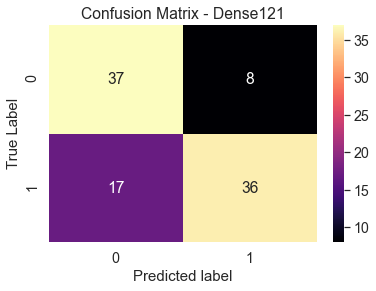

<Figure size 720x504 with 0 Axes>

              precision    recall  f1-score   support

           0       0.69      0.82      0.75        45
           1       0.82      0.68      0.74        53

    accuracy                           0.74        98
   macro avg       0.75      0.75      0.74        98
weighted avg       0.76      0.74      0.74        98



In [10]:
preds2 = np.array([1 if x >= cutoff else 0 for x in preds])
cm = confusion_matrix(y, preds2)
#turn this into a dataframe
matrix_df = pd.DataFrame(cm)
#plot the result
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
#set axis titles
ax.set_title('Confusion Matrix - Dense121')
ax.set_xlabel("Predicted label", fontsize =15)
ax.set_ylabel("True Label", fontsize=15)
plt.savefig('fullmaskedcm.png')
plt.show()
print(classification_report(y, preds2))

In [13]:
print(pd.DataFrame(classification_report(y, preds2, output_dict=True)).transpose().to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  precision &    recall &  f1-score &    support \\
\midrule
0            &   0.685185 &  0.822222 &  0.747475 &  45.000000 \\
1            &   0.818182 &  0.679245 &  0.742268 &  53.000000 \\
accuracy     &   0.744898 &  0.744898 &  0.744898 &   0.744898 \\
macro avg    &   0.751684 &  0.750734 &  0.744871 &  98.000000 \\
weighted avg &   0.757112 &  0.744898 &  0.744659 &  98.000000 \\
\bottomrule
\end{tabular}



To Do:

- Tuning nos k-folds
- Gradcam
